In [ ]:
# @title

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cs985-987-relevance-prediction-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72713%2F7984788%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T003551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dd343d50983d7d0ac9d9b820420d45b3f655dddfd82b032a3357c1c2b4afff1f7f743b5a4966b0484a311ea31da65cabe0936c4439993f3e4389cca124ad8c65b946e2c2fe94c66659cd4a8625fe44d81e46a2568c4fbd580466bf32b2ce5a097e38ce22e43a7f38592c45ff365279a1a81ef5d7d221e3da430face5f252bb57cf33956175f8e693ad2651b951064f7339368be341ea06e59b7ae6813403ccba5e62b04efe836d2959e864fc4fc1449a2acd4542ccce5df399da5d71cc609105b03f2fd340ce9f7bd1a3f858fd4f142a2585f7f14bb481df8b2d962833bd4634c3846cee028b136d9c8bf431e6070e9721f4cc78464cce9f24c1ee98c27cf1222,trained-model:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4767099%2F8102095%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T003551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D87999b5b1704aeb940c0bccb0d9bfcbae05c676cec06e7ef0ad86e52da65546000ffe43f2991b847ea7dcbb15a36080c53ceed3e7b3250d88e6b172848c4662b650346cd52dd36157bded8ab0ed6d7bc9933bf8f22c5308a375b0841668cd07dc4d8b3670e229fc0ba1e87519bf5e48f9e94cdad201ed93942bc84306198106fbe5507cc66b3131d73524f1dee99a675bea1dbddf91b300400f369839e27f81c7f29a4e0b8c5b948e3e5bb5f2e37b1c8c33a1dbae4179fc1ab8aee75be66a2e49c5ee8665ee6b439e30f05695d2ca06faad3b30bf0f77a2c5c7c9d92be74bf10c7d18cc34989fdfe6f075fca9d3eb6e31dd9b7501600d791767348cdba9431df,glove-6b:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4765873%2F8102129%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T003551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9068242499b536faad61db4bd2b78f55dbd35a3193dced626134e466a6b721c893a940db01e4e84ded89a9b2a8cf074a7471d0a9971bd5a2547e149d5acc833bb8313a2b3ae9ce858a18a0df0c027b32e5bcdcae4ddb7ea600a7ebf6699d969ace8fd28c096be75f726801ad793d9a0581879168648b9ba960b9bc1cf75b70b5ffb3b1b3c028c7748fdca66744f27e3d44f92312e1dbdfd0092c0b88be0fcb866f623cc59bb5a81bbd366fe3530c2a265853cb38a3edcd81839f410ca1bcf325b8529c696fef344e858d6af7edf26b5c2b6688c2e9b0aa3eb837d6794bf1a365aed04f236028f0221e2a8659f01f816f665c4c88f84746822d3d583844a20a78'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Participants
- Mohamed Tarek Mokhtar Omara Ahmed
- S A Nawash Akhtar
- Nguyen Trung Duc
- Riley Simpson

# Overview
This study goes into text mining using machine learning techniques, primarily focusing on deep learning. We aimed to accurately identify relevant pairing between presented document and inputed search topics, a task with widespread application, in pairing Q&A, similar text identification, .... The project involved exploration and cleaning of the dataset, followed by the application of various ML models. Our findings and recommendations are based on the performance of these models, offering insights into various approach that we can apply to improve the quality of our prediction.

# Method
We began with an analysis of the dataset to determine the cleaning process and understand the distribution of the binary classes to determin the right metrics.

In data splitting, we used a 85% training, 10% validation, and 5% testing split, ensuring we can have optimal sample for our training process. Given the high level of complexity and high dimensionality of the data we are working with, most of the deep neural models are run on a P100 GPU

# Models
1. Standard ML Baseline: We employ various common model including Naive Bayes, Logistic regression, SVM, Random Forest, XGBoost to cover different type of pattern we may encounter.

2. Deep Neural Networks (DNNs): We then experimented with various DNN configurations, adjusting layers count and nodes count, along with different activation functions. And fine that aligned with current believe, gelu work particularly well for textual task.

3. Complex Models : We developed several complex CNN architectures, employing Siamese architecture to pair Document and Topics, expecting better results.

  - **Model 1**: Using typical deep neural network, with different optimal parameter we found in the DNN part, but we apply the pre-trained GloVe embedding as weight initiator
  - **Model 2**: Using GloVe Embedding with LSTM and Bidirectional LSTM as we are working with textual sequential data
  - **Model 3**: Using Siamese architecture with input separately for Document and Topic, to process them separately, this approach is expect to be good for a different between the size of text between the document (whole paragraph) againt short sentence for the topic. And then we measure the similarity based on distance between the embedding of the input
  - **Model 4**: Using CNN in a Siamese architecture. While CNN is primarily applicable for images, it can also potentially find pattern in local pattern within the paragraph
  - **Model 5**: Due to BERT being relatively larger than the hardware available to use, we use a lighter weight approach by using Bert Sentence embedding to process the 2 input and compare the distance for similarity
  - **Models 6**: a typical approach applying both the Siamese and Bidirectional to find both the sequential and semantic simialrity between the 2 inputs




### 1. Data Setup

tensorflow and keras require consistency, and pandas may behave drastically different with different version so we need to specify here


In [ ]:
# @title
!pip install keras==2.15.0
!pip install tensorflow==2.15.0
!pip install pandas==2.2.1
#!pip install nltk
#!pip install xgboost
#!pip install gensim
#!pip install bs4
#!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 71.9 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.5 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Libraries for text preprocessing
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

from scipy.sparse import hstack

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Libraries for vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder

# Libraries for ML
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score, f1_score,precision_recall_curve

import random
import warnings
warnings.simplefilter(action='ignore')

2024-04-12 21:59:19.026983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 21:59:19.027103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 21:59:19.167812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In order to ensure results reproducibility, we set the random seeds for numpy, tensorflow and the python random package to a constant value of 42. We then made use of the python pandas library to read the data into memory:

In [ ]:
# @title
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# @title
#Storing the output path of the .csv files to be downloaded
training_df, testing_df= '/kaggle/input/cs985-987-relevance-prediction-2024/relevance_train.parquet', '/kaggle/input/cs985-987-relevance-prediction-2024/relevance_test.parquet'

#Reading the .parquet files into a DataFrame
training_df, testing_df=pd.read_parquet(training_df), pd.read_parquet(testing_df)

training_df.head()

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
0,004c6120d0aa69da29cc045da0562168,0,Terrence McCoy,"<p>More than 60 years ago, a fair-skinned Iris...",By Terrence McCoy,Report on Irish baby homes documents use of in...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
1,005a1f0c2064487a7f15443b2a5f349a,0,Brian McNoldy,"<p>Hurricane Fred, which formed over the weeke...",By Brian McNoldy,Hurricane Fred is a fountain of ‘firsts’ in th...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
2,00722094-2935-11e2-b4e0-346287b7e56c,0,Editorial Board,"<p>EIGHT YEARS AGO this month, an inspiring mo...",By Editorial Board,Ukraine slides away from democracy,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
3,007d2856-7cc4-11e4-84d4-7c896b90abdc,0,Adam Bernstein,"<p>Mary Burke Washington, an economist who was...",By Adam Bernstein,"Mary Washington, government official and widow...",321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
4,009aafb6-0283-11e6-8bb1-f124a43f84dc,0,None,"<p>When Treasury Secretary Jack Lew <a href=""h...",None,Will women be shortchanged again?,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments


### 2. Exploratory Data Analysis

The basic format of the dataset we are working with including 2 main parts, the 'document' that we need to search through, (made up of columns 'title' and 'body'), and the 'topic' that we are interested in retrieving, (made up of columns 'description and 'narrative').   
We are working with an imbalance dataset, with only 1/9 documents are relevant to us

In [ ]:
# @title
# Check target distribution
judgement_counts = training_df['judgement'].value_counts()
total = judgement_counts.sum()
percentages = (judgement_counts / total) * 100
print(percentages)

judgement
0    84.284847
1    15.715153
Name: count, dtype: float64


For relevance judgement, we consider the informative features about the article, and the user's query terms. Specifically we used the body and title features as representations of the article, and the topic_title and description features as representations of the user's query.

In [ ]:
# @title
# visualization of the first 5 records
training_df.head()

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
0,004c6120d0aa69da29cc045da0562168,0,Terrence McCoy,"<p>More than 60 years ago, a fair-skinned Iris...",By Terrence McCoy,Report on Irish baby homes documents use of in...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
1,005a1f0c2064487a7f15443b2a5f349a,0,Brian McNoldy,"<p>Hurricane Fred, which formed over the weeke...",By Brian McNoldy,Hurricane Fred is a fountain of ‘firsts’ in th...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
2,00722094-2935-11e2-b4e0-346287b7e56c,0,Editorial Board,"<p>EIGHT YEARS AGO this month, an inspiring mo...",By Editorial Board,Ukraine slides away from democracy,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
3,007d2856-7cc4-11e4-84d4-7c896b90abdc,0,Adam Bernstein,"<p>Mary Burke Washington, an economist who was...",By Adam Bernstein,"Mary Washington, government official and widow...",321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
4,009aafb6-0283-11e6-8bb1-f124a43f84dc,0,None,"<p>When Treasury Secretary Jack Lew <a href=""h...",None,Will women be shortchanged again?,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments


In [ ]:
# @title
# create a copy of the original dataset
training_df2 = training_df.copy()
# extract the useful representative features
training_df2 = training_df2.reindex(columns=['judgement','body','description','title','narrative'])

From the exploratory data analysis we can see that the training dataset has a imbalance dstribution for the two class named 'judgement'. The percentage of the '0' values is approximate 84.28% and the percentage for the '1' is around 15%. The 0 reflects the unrelevant judgment and 1 is relevant judgment. The imbalance shows that the most article was misjudged, which is not relevant to the users need. To consider the relevance judgement, we have take account of four key features. The 'body' and the 'title' is the actual content and title of the article. The 'description' and 'narative' is basically the user searches or need. To get the clearer picture we have shown the individual entries for the above important features. Finally we have created a copy of the dataset and reindexed the most important columns for assessing the article relevance.

### 3. Text preprocessing

In [ ]:
# @title
# Check missing values
training_df2.isna().sum()

judgement       0
body           69
description     0
title           0
narrative       0
dtype: int64

In [ ]:
testing_df.isna().sum()

doc_id           0
author         300
body            10
byline         300
title            0
topic_id         0
description      0
narrative        0
topic_title      0
dtype: int64

In [ ]:
# @title
# Replace the null values with empty text
training_df2.dropna(inplace=True) # intuitively, without knowing the body, it is almost impossible to find out if it is going to be a match
testing_df.fillna('', inplace=True) # to retain the shape of the submission we choose to keep the empty values in the testing
# Preprocessing function
def preprocess_text(text):
  # remove html links, anchor tags and paragraph tags
  soup = BeautifulSoup(text,'html.parser')
  text = soup.get_text()

  text = text.lower()
  # remove unncessary backslashes
  text = re.sub(r'[^\w\s()/\\]', ' ',text)

  # remove unnecessary next line string tags
  text = text.replace('\\n', '')

  # the text has a consistent 'xa0' string - remove it
  text = text.replace('\xa0', ' ')

  # tokenize - remove punctuations - remove stopwords - lemmatize
  tokens = word_tokenize(text)

  # remove punctuations
  tokens = [word for word in tokens if word not in string.punctuation]

  # remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word.lower() not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  sentence = ' '.join(tokens)

  return sentence

often the file from nltk does not automatically unzip after being download so we have a code to explicityly perform this base on the default path on kaggle and colab

In [ ]:
# @title
import os
import zipfile

# Define the directories to try
directories_to_try = ["/root/nltk_data", "/usr/share/nltk_data"]

# Try each directory until successful
found = False
for directory in directories_to_try:
    try:
        # Check if the directory exists
        if os.path.exists(directory):
            # Define the path to the WordNet zip file
            wordnet_zip_path = os.path.join(directory, "corpora", "wordnet.zip")
            # Check if the WordNet zip file exists
            if os.path.exists(wordnet_zip_path):
                # Unzip WordNet data
                with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
                    zip_ref.extractall(os.path.join(directory, "corpora"))
                found = True
                break
    except Exception as e:
        print(f"Error: {e}")

if not found:
    print("WordNet data not found in either directory.")

In [ ]:
# @title
# columns to clean in training
columns_to_clean = ["title", "body","description","narrative" ]

# applying cleaning function to each column
training_df2 = training_df2[columns_to_clean].map(preprocess_text)
testing_df = testing_df[columns_to_clean].map(preprocess_text)

# we re-attached the judgement column back to training_df2
training_df2['judgement'] = training_df['judgement']

In [ ]:
# @title
print(training_df2['body'][0])
print(training_df2['description'][0])
print(training_df2['title'][0])
print(training_df2['narrative'][0])

60 year ago fair skinned irish politician named sally mulready born home unwed mother called st patrick sat road named navan dublin mulready one four sibling born brother john never made st pat like hundred baby born irish home fallen woman john died 1947 two month old inanition death record read according rte news failure thrive rte news said record carried mystery john reason buried 1950 three year death oddity first discarded clerical error john record designation anatomical study infant remains fact given researcher trinity college dublin used medical research though unclear whether mother given consent mulready eventually tracked burial plot explained irish time found marked stick number imagine happening child young baby died well family family influence happen baby beside john according recent irish government report confirming augmenting earlier report rte investigation called anatomy scandal report preliminary review designed set framework full formal investigation ordered iri

In [ ]:
# @title
def grouping_col(data):
  data['document'] = data['title'] + ' ' + data['body']
  data['topic'] = data['description'] + ' ' + data['narrative']
  data['concatenated_text'] = data['document'] + '[SEP]' + data['topic'] # [SEP] are default denominator for splitting text, will be relevant when apply on BERT
  return data

training_df2 = grouping_col(training_df2)
testing_df = grouping_col(testing_df)
df_combine = training_df2.copy()

We will explore the 'Text Preprocessing' steps which was done on the 'training_df2' dataset, a copied dataset after doing eda and on the 'testing_df'. We will check the missing values on both of the datasets. Train dataset has missing values on the 'body' column and testing dataset has multiple columns missing values. We will drop the null values for training dataset and empty string will replace the testing datasets null values to maintain the structure.

We have defined a function and used it to clean the texts of the datasets. First we have removed the HTML content, convert the text to lower case and removed unwanted specific characters. We also tokenized the text, removed punctuation, removed stopwords and applied lemmatization. We have cleaned four columns 'title', 'body', 'description' and 'narrative' on the both train and test datasets. After the cleaning process we have added the 'judgement' column from the original traning dataset to preserve the label data for further process.

### 4. Machine Learning Models

#### Data Preprocessing

In [ ]:
# @title
# Split texts and labels for train data
train_text, test_text, train_label, test_label = train_test_split(df_combine.drop('judgement', axis =1), # features
                                                                    df_combine['judgement'], # target
                                                                    test_size = 0.1, # 90% train 10% valid
                                                                    random_state = 42,
                                                                    shuffle = True, # shuffle data before splitting
                                                                    stratify = df_combine[['judgement', 'narrative']]) # distribution of class across train and valid
train_text.reset_index(drop = True, inplace = True)
train_label.reset_index(drop = True, inplace = True)
test_text.reset_index(drop = True, inplace = True)
test_label.reset_index(drop = True, inplace = True)

To preprocess our data in order for the model be able to learn, we apply TF-IDF,a commonly used technique in natural language processing to convert text documents into numerical vectors while considering the importance of each word in the document relative to a collection of documents.

In [ ]:
# @title
# Tf-idf encoding
ngram_range = (1, 2) # Range (inclusive) of n-gram sizes for tokenizing text.
top_k = 10000 # Limit on the number of features. We use the top 10K features.
token_mode = 'word' # Whether text should be split into word or character n-grams.
min_doc_freq = 2 # Minimum document/corpus frequency below which a token will be discarded.


def ngram_vectorize(train_texts, train_labels, val_texts):
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': token_mode,  # Spliting text into tokens.
            'min_df': min_doc_freq,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

X_train, X_test = ngram_vectorize(train_text['concatenated_text'], train_label, test_text['concatenated_text'])
ml_results = {} # To track the models performance

#### Naive Bayes

In [ ]:
# @title
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
'''
# Define hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 10.0]  # Laplace smoothing parameter
}

# Initialize MultinomialNB model
nb_model = MultinomialNB()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='f1', cv=3)

# Perform GridSearchCV
grid_search.fit(X_train, train_label)

# Get best hyperparameters and best estimator
best_alpha = grid_search.best_params_['alpha']
best_nb = grid_search.best_estimator_

# Predict results
y_test_pred = best_nb.predict(X_test)
print("Best Alpha:", best_alpha)

'''
# Train the model using the tuned param
nb_model = MultinomialNB(alpha= 0.1)
nb_model.fit(X_train, train_label)
y_test_pred = nb_model.predict(X_test)
# Record the results
accuracy, precision, recall, f1 = accuracy_score(test_label, y_test_pred), precision_score(test_label, y_test_pred), recall_score(test_label, y_test_pred), f1_score(test_label, y_test_pred)
pred_count = sum(y_test_pred)
total_instances = sum(test_label)
ml_results['Naive Bayes'] = [accuracy, precision,recall,f1,pred_count, total_instances]

# Print results
print("\nTest Set Performance:")
print(classification_report(test_label, y_test_pred))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1660
           1       0.89      0.14      0.24       309

    accuracy                           0.86      1969
   macro avg       0.88      0.57      0.58      1969
weighted avg       0.87      0.86      0.82      1969



#### Logistic Regression

In [ ]:
# @title
from sklearn.linear_model import LogisticRegression
'''
# Define hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2']  # This is fixed as you are using 'l2' penalty
}

# Initialize LogisticRegression
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid, scoring='f1', cv=3)

# Perform GridSearchCV
grid_search.fit(X_train, train_label)

# Get best hyperparameters and best estimator
best_params = grid_search.best_params_
best_log = grid_search.best_estimator_

# Predict results
y_test_pred = best_log.predict(X_test)

# Print results
print("Best Hyperparameters:")
print(best_params)
'''
# Run the model with the tuned param
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, C=10, penalty='l2')
log_model.fit(X_train, train_label)
y_test_pred = log_model.predict(X_test)

# Measure results
accuracy, precision, recall, f1 = accuracy_score(test_label, y_test_pred), precision_score(test_label, y_test_pred), recall_score(test_label, y_test_pred), f1_score(test_label, y_test_pred)
pred_count = sum(y_test_pred)
total_instances = sum(test_label)
ml_results['Logistic Regression'] = [accuracy, precision,recall,f1,pred_count, total_instances]

print("\nTest Set Performance:")
print(classification_report(test_label, y_test_pred))



Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1660
           1       0.45      0.70      0.55       309

    accuracy                           0.82      1969
   macro avg       0.69      0.77      0.72      1969
weighted avg       0.86      0.82      0.83      1969



#### SVM

In [ ]:
# @title
from sklearn.svm import SVC
'''
# Define hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Initialize SVC
svm_model = SVC(class_weight='balanced', max_iter=1000, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='f1', cv=3)

# Perform GridSearchCV
grid_search.fit(X_train, train_label)

# Get best hyperparameters and best estimator
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_
print("Best Hyperparameters:")
print(best_params)
#{'C': 10, 'kernel': 'rbf'}

# Predict results
y_test_pred = best_svm.predict(X_test)
'''
# Training the model on the tuned param
svm_model = SVC(class_weight='balanced', max_iter=1000, random_state=42, C=10, kernel='rbf')
svm_model.fit(X_train, train_label)
y_test_pred = svm_model.predict(X_test)

# Measure the results
accuracy, precision, recall, f1 = accuracy_score(test_label, y_test_pred), precision_score(test_label, y_test_pred), recall_score(test_label, y_test_pred), f1_score(test_label, y_test_pred)
pred_count = sum(y_test_pred)
total_instances = sum(test_label)
ml_results['SVM'] = [accuracy, precision,recall,f1,pred_count, total_instances]

# Print results
print("\nTest Set Performance:")
print(classification_report(test_label, y_test_pred))



Test Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      1660
           1       0.15      0.28      0.19       309

    accuracy                           0.63      1969
   macro avg       0.49      0.49      0.47      1969
weighted avg       0.73      0.63      0.67      1969



#### Random Forest

In [ ]:
# @title
from sklearn.ensemble import RandomForestClassifier
'''
# Define hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20]
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=3)

# Perform GridSearchCV
grid_search.fit(X_train, train_label)

# Get best hyperparameters and best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
# Predict results
y_test_pred = best_rf.predict(X_test)
# Print results
print("Best Hyperparameters:")
print(best_params)
#{'max_depth': 20, 'n_estimators': 100}

'''
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth = 20, n_estimators = 100)
rf_model.fit(X_train, train_label)
y_test_pred = rf_model.predict(X_test)

accuracy, precision, recall, f1 = accuracy_score(test_label, y_test_pred), precision_score(test_label, y_test_pred), recall_score(test_label, y_test_pred), f1_score(test_label, y_test_pred)
pred_count = sum(y_test_pred)
total_instances = sum(test_label)
ml_results['Random Forest'] = [accuracy, precision,recall,f1,pred_count, total_instances]

print("\nTest Set Performance:")
print(classification_report(test_label, y_test_pred))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1660
           1       0.58      0.40      0.48       309

    accuracy                           0.86      1969
   macro avg       0.74      0.68      0.70      1969
weighted avg       0.85      0.86      0.85      1969



#### XGBoost

In [ ]:
# @title
import xgboost as xgb
'''
# Define Parameter Grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3)

# Perform GridSearchCV
grid_search.fit(X_train, train_label)

# Get best hyperparameters and best estimator
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

# Predict results
y_test_pred = best_xgb.predict(X_test)

print("Best Hyperparameters:")
print(best_params)
#{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
'''
# Using the tuned parameter from previous experimentations
xgb_model = xgb.XGBClassifier(random_state=42, learning_rate=0.1, max_depth=7, n_estimators = 300)
xgb_model.fit(X_train, train_label)
y_test_pred = xgb_model.predict(X_test)

accuracy, precision, recall, f1 = accuracy_score(test_label, y_test_pred), precision_score(test_label, y_test_pred), recall_score(test_label, y_test_pred), f1_score(test_label, y_test_pred)
pred_count = sum(y_test_pred)
total_instances = sum(test_label)
ml_results['XGBoost'] = [accuracy, precision,recall,f1,pred_count, total_instances]

# Print results
print("\nTest Set Performance:")
print(classification_report(test_label, y_test_pred))



Test Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      1660
           1       0.78      0.38      0.51       309

    accuracy                           0.89      1969
   macro avg       0.84      0.68      0.72      1969
weighted avg       0.88      0.89      0.87      1969



#### Model Comparison

In [ ]:
# @title
# Convert the dictionary into a pandas DataFrame
ml_results_df = pd.DataFrame.from_dict(ml_results,
                                    orient='index',
                                    columns=['accuracy','precision','recall','f1_core','count_predictions','total_instances'])
# Display the results as a table
print("Model Performance Comparison:")
print(ml_results_df)

Model Performance Comparison:
                     accuracy  precision    recall   f1_core  \
Naive Bayes          0.861859   0.893617  0.135922  0.235955   
Logistic Regression  0.817166   0.447423  0.702265  0.546599   
SVM                  0.625698   0.145695  0.284790  0.192771   
Random Forest        0.860843   0.581395  0.404531  0.477099   
XGBoost              0.885729   0.783784  0.375405  0.507659   

                     count_predictions  total_instances  
Naive Bayes                         47              309  
Logistic Regression                485              309  
SVM                                604              309  
Random Forest                      215              309  
XGBoost                            148              309  


# 5. Neural Network

## 5.1. Preprocessing for NN and DNN

In [ ]:
# @title
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
X_train_nn, y_train = X_train.copy().toarray(), train_label.copy()
X_val_nn, y_val = X_test.copy().toarray(), test_label.copy()

## 5.2. Neural Network baseline with different neuron count

In [ ]:
# @title
# Setting a fixed seed
tf.random.set_seed(42)

# Define a neural network function
def nn(neu_num, dr_rate=0.5):
    model = keras.models.Sequential([
        keras.layers.Dense(neu_num, activation="relu", input_shape=X_train_nn.shape[1:]),
        Dropout(dr_rate),
        keras.layers.Dense(neu_num, activation="relu"),
        Dropout(dr_rate),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

neuron_usage = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Compute class weights for class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

y_train_np = y_train.to_numpy()

# Training neural network model
for i in neuron_usage:
    model = nn(i)
    model.fit(X_train_nn, y_train_np, epochs=10, validation_split=0.2, verbose=0, class_weight=class_weight_dict)

    predictions_prob = model.predict(X_val_nn)
    predictions = (predictions_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Creating dataframe for accuracy, precision, recall and F1 score
metrics_dict = {
    'Number of Neurons': neuron_usage,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
}

metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

I0000 00:00:1712959746.313146     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 [==============================] - 0s 2ms/step
    Number of Neurons  Accuracy  Precision    Recall  F1 Score
0                  10  0.842560   0.498795  0.669903  0.571823
1                  50  0.862875   0.560000  0.588997  0.574132
2                 100  0.847131   0.511299  0.585761  0.546003
3                 200  0.853225   0.529762  0.576052  0.551938
4                 300  0.856780   0.545151  0.527508  0.536184
5                 400  0.851193   0.523669  0.572816  0.547141
6                 500  0.858812   0.550162  0.550162  0.550162
7                 600  0.850686   0.522659  0.559871  0.540625
8                 700  0.857796   0.550877  0.508091  0.528620
9                 800  0.852209   0.526316  0.582524  0.552995
10                900  0.855256   0.535928  0.579288  0.556765
11               1000  0.857796   0.550877  0.508091  0.528620


Here, we have created neural network models to address this classification problem. We have used the TensorFlow Keras for this neural network architecture. The model is created with sequennce of dense layers and variable number of neurons. Also we have used dropout layers to avoid any kind of overfitting problem. To test the varibale number of neurons we have explored 10 to 1000 neurons in the hidden layers. We have used the computed class weights to address the imbalance in the dataset.

We have used several metrics to evaluate the models performance, which includes accuracy, precision, recall and F1 score. The accuracy of the neurons is around 85%. It means that the model correctly predicts the outcome 85% instances of the validation set. But this takes account for both positive and negative predictions. Where as we can see that the precisions are in the range from 49% to 56% so almost half of the time the positive predictios are correct. This values suggest that the model is somewhat  relibale for the posotive predictions, although it hase large portions of false positive that means the model is also facing some chalenges to separate between psoitive and negative preictions. On the other hand,  recall ranges from 50% to 66%, the actual positive predictions. So the model misses about 40%-60% of actual positive predictions. It lacks to detect the relevant cases. The F1 score ranges 53% to 57%, means the model has a moderate balance between precision and recall. The model has some more room for improement where we it could get more optimal balance for both precison and recall.

Also the precision is highest for 1000 neurons and same time lowest recall, whereas the recall is highest for 10 neurons and has lowest precision. So more neurons are precise in positive predictions and fewer neurons can predict more actual positive values.

In [ ]:
# @title
# Average values of accuracy, precision, recall and F1 score
average_metrics = {
    'Average Accuracy': metrics_df['Accuracy'].mean(),
    'Average Precision': metrics_df['Precision'].mean(),
    'Average Recall': metrics_df['Recall'].mean(),
    'Average F1 Score': metrics_df['F1 Score'].mean()
}

for metric, value in average_metrics.items():
    print(f'{metric}: {value}')

Average Accuracy: 0.8538598273235145
Average Precision: 0.5337912002466124
Average Recall: 0.5674217907227616
Average F1 Score: 0.5487506651529979


The average values of the NN model indicates that it has high accuracy for the both positive and negative prections. But the mean values of precision, recall and F1 score suggest that the model has a moderate balance between them and the model could be improved in some areas.

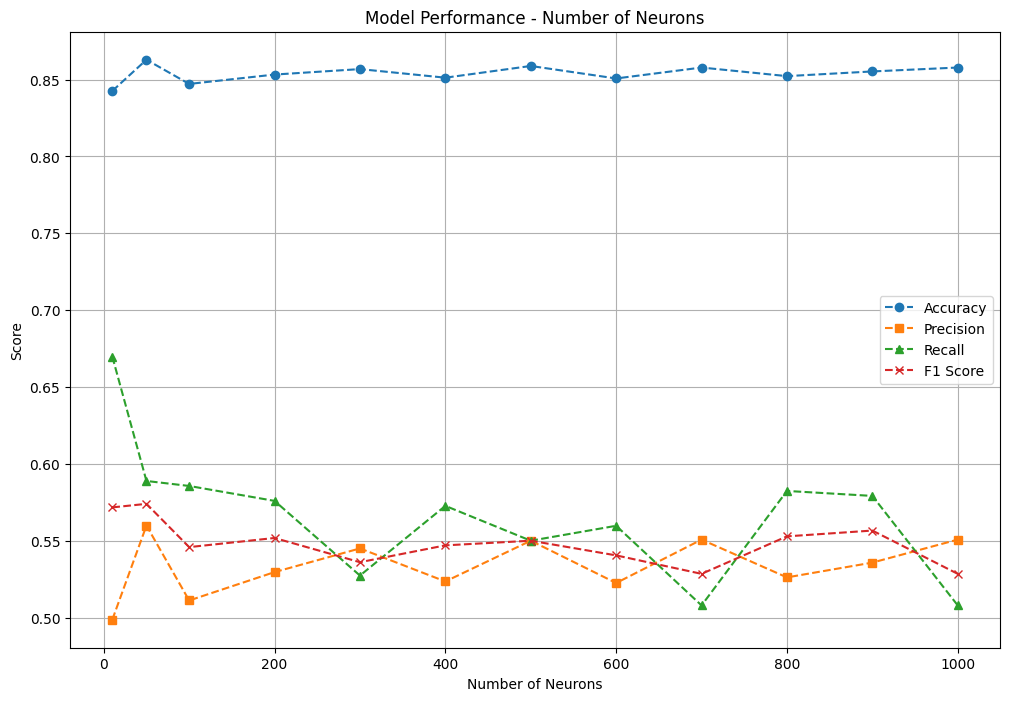

In [ ]:
# @title
# Creating a plot to show the performance of the model for Number of Neurons
plt.figure(figsize=(12, 8))
plt.plot(neuron_usage, accuracies, label='Accuracy', marker='o', linestyle='--')
plt.plot(neuron_usage, precisions, label='Precision', marker='s', linestyle='--')
plt.plot(neuron_usage, recalls, label='Recall', marker='^', linestyle='--')
plt.plot(neuron_usage, f1_scores, label='F1 Score', marker='x', linestyle='--')
plt.xlabel('Number of Neurons')
plt.ylabel('Score')
plt.title('Model Performance - Number of Neurons')
plt.legend()
plt.grid(True)
plt.show()

In the above plot we can see the performance of neural network modles for various number of neurons. The metrics for the performance is accuracy, precision, recall and F1 score. The accuracy line remains high in the plot indicates high accuracy for both positive and negative values. But the precesion, recall and F1 score has more variability against the neuron counts. Precision goes up and recall dips down at the higest neuron (1000) and for 10 neurons its vice versa situation. The F1 score line suggest strong balance between recall and precision.

From all the analysis above it can be said that, the best spot for the number of neurons is around 10 to 50 where the model achieves the higest F1 score. Which indicates most balanced precision and recall also maintains a high accuracy.

## 5.3. Deep NN models with different layer depth

In [ ]:
# @title
# Define a deep neural network function
def dnn(layer_num, active_func, dr_rate=0.5):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(50, activation=active_func, input_shape=X_train_nn.shape[1:]))
    model.add(Dropout(dr_rate))

    for i in range(layer_num - 1):
        model.add(keras.layers.Dense(50, activation=active_func))
        model.add(Dropout(dr_rate))

    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Creating a list of layers for further process
layer_usage = [1, 2, 3, 4, 5, 6]
results_dnn = {}

dnn_accuracies = []
dnn_precisions = []
dnn_recalls = []
dnn_f1_scores = []

# Training deep neural network model
for i in layer_usage:
    model = dnn(i, "relu")
    model.fit(X_train_nn, y_train_np, epochs=10, validation_split=0.2, verbose=0, class_weight=class_weight_dict)

    predictions_prob = model.predict(X_val_nn)
    predictions = (predictions_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    dnn_accuracies.append(accuracy)
    dnn_precisions.append(precision)
    dnn_recalls.append(recall)
    dnn_f1_scores.append(f1)
# Creating dataframe for accuracy, precision, recall and F1 score
metrics_dict_dnn = {
    'Number of Layers': layer_usage,
    'Accuracy': dnn_accuracies,
    'Precision': dnn_precisions,
    'Recall': dnn_recalls,
    'F1 Score': dnn_f1_scores
}

metrics_df_dnn = pd.DataFrame(metrics_dict_dnn)
print(metrics_df_dnn)

62/62 [==============================] - 0s 2ms/step
   Number of Layers  Accuracy  Precision    Recall  F1 Score
0                 1  0.846623   0.509091  0.634304  0.564841
1                 2  0.857288   0.540936  0.598706  0.568356
2                 3  0.849162   0.516393  0.611650  0.560000
3                 4  0.848146   0.512821  0.647249  0.572246
4                 5  0.846623   0.509485  0.608414  0.554572
5                 6  0.837481   0.486486  0.640777  0.553073


Now we will define a deep neural network named 'dnn' and compare its outcome with the NN model we did on last step. We will again create the dnn with Keras and our main traget will be to evaluate varous layers with the created network. We will have a input layers in the start of the confuguration then will use hidden layers, based on the predefined layers list. The number of neurons will be 50 and ReLu activation function will be used here. Dropout layer wil be added after each layer. We will use sigmoid function on he output layer which is suitable for this kind of binary classification problem.

We will test the network up to six layers maintaining fixed number of neurons and activation function so that we can compare the performance for the varous layer usage. Like the NN method we will measure the performance of the model based on accuracy, precision, recall and F1 score. From the output we cann see that, the accuracy for all the layers are more than 80% which indicates that the model correctly predicts 80% of the time for both positive and negative. The NN modles accuracy was around 85% more than DNN. The precision of the dnn ranges from 48% to 50% which is very similar to the NN precision. And it means that both NN and DNN correctly predicts the positive values half of the time. The recall is from 59% to 66%. The DNN has more acurate positive prediction than the nn predictions. Also the F1 score is more than the NN. Which means the DNN is more balanced between precision and recall than the NN model. In the end we can say that the DNN model performs slighly better that the NN prediction of the positive values.

In [ ]:
# @title
# Average values of accuracy, precision, recall and F1 score
average_metrics_dnn = {
    'Average Accuracy': metrics_df_dnn['Accuracy'].mean(),
    'Average Precision': metrics_df_dnn['Precision'].mean(),
    'Average Recall': metrics_df_dnn['Recall'].mean(),
    'Average F1 Score': metrics_df_dnn['F1 Score'].mean()
}

for metric, value in average_metrics_dnn.items():
    print(f'{metric}: {value}')

Average Accuracy: 0.8475537497883868
Average Precision: 0.5125353530644046
Average Recall: 0.6235167206040992
Average F1 Score: 0.5621814727100196


We have calculated the mean values for accuracy, precision, recall and F1 score for the DNN method. The accuracy of the DNN is slighltly lower than the NN method. But the reacll and F1 score is higher in DNN than the NN predictions. Which means DNN is better at identifying the positive values and is more balanced than the NN methods. For the  other matrics, precision, NN is more than the DNN. If we consider the above matrics we can say that because the DNN predicts positive cases more effectively it is slightly better performing than the NN.

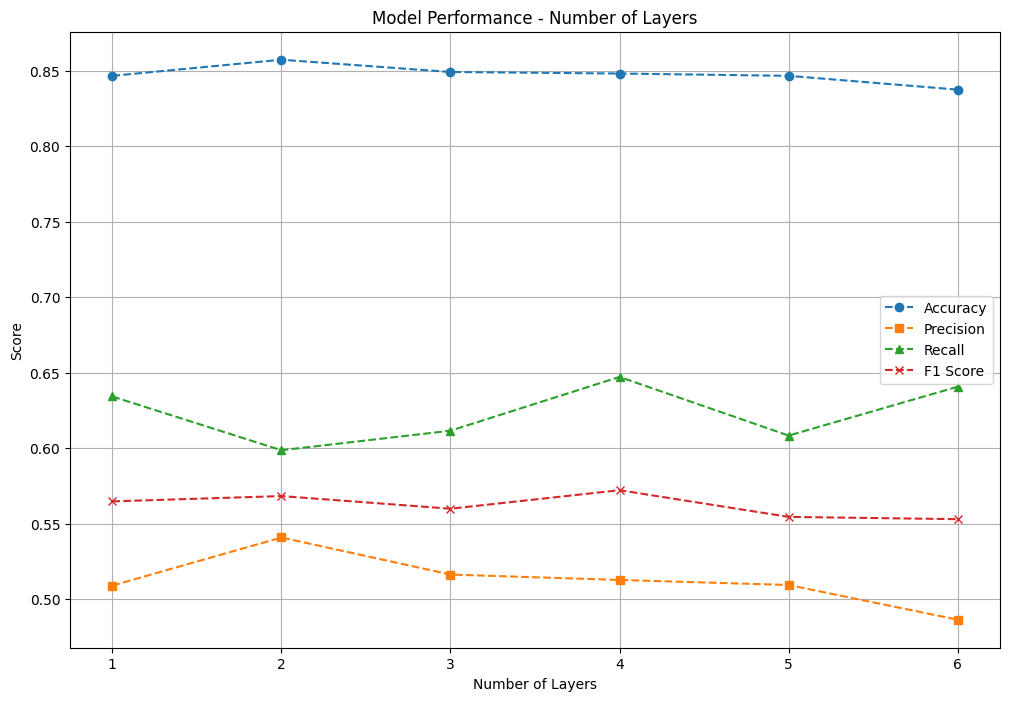

In [ ]:
# @title
# Creating a plot to show the performance of the model for Number of Layers
plt.figure(figsize=(12, 8))
plt.plot(layer_usage, dnn_accuracies, label='Accuracy', marker='o', linestyle='--')
plt.plot(layer_usage, dnn_precisions, label='Precision', marker='s', linestyle='--')
plt.plot(layer_usage, dnn_recalls, label='Recall', marker='^', linestyle='--')
plt.plot(layer_usage, dnn_f1_scores, label='F1 Score', marker='x', linestyle='--')
plt.xlabel('Number of Layers')
plt.ylabel('Score')
plt.title('Model Performance - Number of Layers')
plt.legend()
plt.grid(True)
plt.show()

In the above plot we can see the deep neural network model performance based on same matrics which is accuracy, precision, recall and F1 score. Accuracy remians high and stable for all the layer configuration. The precision, recall and F1 score have similar values for the layer two. From the layer two the recall incresed, the precision decresed and F1 score remains almost in the similar range.

In end, we can say that the deeper layers are not equate to better performance. We get the highest F1 score in the layer 4 and it drops again if we go more deeper layers. So basically its the not the deeper layer which has the most balanced prediction.

## 5.4. Deep NN models with different activation function

In [ ]:
# @title
# Define a list of activation function for further process
activation_funcs = ["relu", "elu", "selu", "gelu", "swish", "mish", "leaky_relu", "tanh"]
results_ac = {}

ac_accuracies = []
ac_precisions = []
ac_recalls = []
ac_f1_scores = []

# Using various activation function for the dnn training
for i in activation_funcs:
    model = dnn(3, i)
    history = model.fit(X_train_nn, y_train_np, epochs=10, validation_split=0.2, verbose=0, class_weight=class_weight_dict)

    predictions_prob = model.predict(X_val_nn)
    predictions = (predictions_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    ac_accuracies.append(accuracy)
    ac_precisions.append(precision)
    ac_recalls.append(recall)
    ac_f1_scores.append(f1)

62/62 [==============================] - 0s 2ms/step


In [ ]:
# @title
# Creating dataframe for accuracy, precision, recall and F1 score
metrics_dict_ac = {
    'Activation Functions': activation_funcs,
    'Accuracy': ac_accuracies,
    'Precision': ac_precisions,
    'Recall': ac_recalls,
    'F1 Score': ac_f1_scores
}

metrics_df_ac = pd.DataFrame(metrics_dict_ac)
print(metrics_df_ac)

  Activation Functions  Accuracy  Precision    Recall  F1 Score
0                 relu  0.852717   0.526171  0.618123  0.568452
1                  elu  0.845099   0.505650  0.579288  0.539970
2                 selu  0.845607   0.506964  0.588997  0.544910
3                 gelu  0.857288   0.542169  0.582524  0.561622
4                swish  0.851193   0.522472  0.601942  0.559398
5                 mish  0.853225   0.528571  0.598706  0.561457
6           leaky_relu  0.856272   0.541401  0.550162  0.545746
7                 tanh  0.846115   0.508671  0.569579  0.537405


Now we will use the deep neural network defined earlier with various activation functions. Activation function are very importat component in neural network, and the optimal choice can vary base on datatypes. We will use several functions: ReLu(Rectified Linear Unit), ELU(Exponential Linear Unit), SELU(Scaled Exponential Linear Unit), GElU(Gaussian Error Linear Unit) etc. We will keep configuration of the DNN with 3 layers throughout this phase. And again will measure the performance of the model on the accuracy, precision, recall and F1 score.

From the above results of the various activation function, we see that GELU has the highest accuracy and second highest f1 score, right next to RELU, which suggest RELU can be a good match for our task. Most RELU-related activation functions aim to preserve linearity in the positive activations and suppressing the negative activations. Leaky-RELU prevents activated units in the negative regime from having a zero-gradient which can prevent neurons from 'dying off', which can occur until other weights change and cause the activation to become positive again. However, Leaky-RELU being scaled-linear in the negative regime means that strong negative activations can have an undesirable impact on the sum of activations feeding into the the unit of the next layer. This forces additional activations to be needed such that constructive and destructive interference balances out. Methods like GELU and Swish are attempting to provide 'some' well defined gradient in the negative regime to stop neurons dying while bounding how far into the negative regime activations are able to have an effect which allows for better mixing of features between layers.

In [ ]:
# @title
# Average values of accuracy, precision, recall and F1 score
average_metrics_ac = {
    'Average Accuracy': metrics_df_ac['Accuracy'].mean(),
    'Average Precision': metrics_df_ac['Precision'].mean(),
    'Average Recall': metrics_df_ac['Recall'].mean(),
    'Average F1 Score': metrics_df_ac['F1 Score'].mean()
}

for metric, value in average_metrics_ac.items():
    print(f'{metric}: {value}')

Average Accuracy: 0.850939563230066
Average Precision: 0.5227585140265223
Average Recall: 0.5861650485436893
Average F1 Score: 0.5523701346338757


The averages from this various usage of activation function and the previous NN and DNN shows that the NN still has the highest accuracy. But the individual DNN method has the highest F1 score. So the DNN method still has the highest balance between precision and recall which mean it has the highest overall effectiveness of identifying the positive values accurately and consistently.  

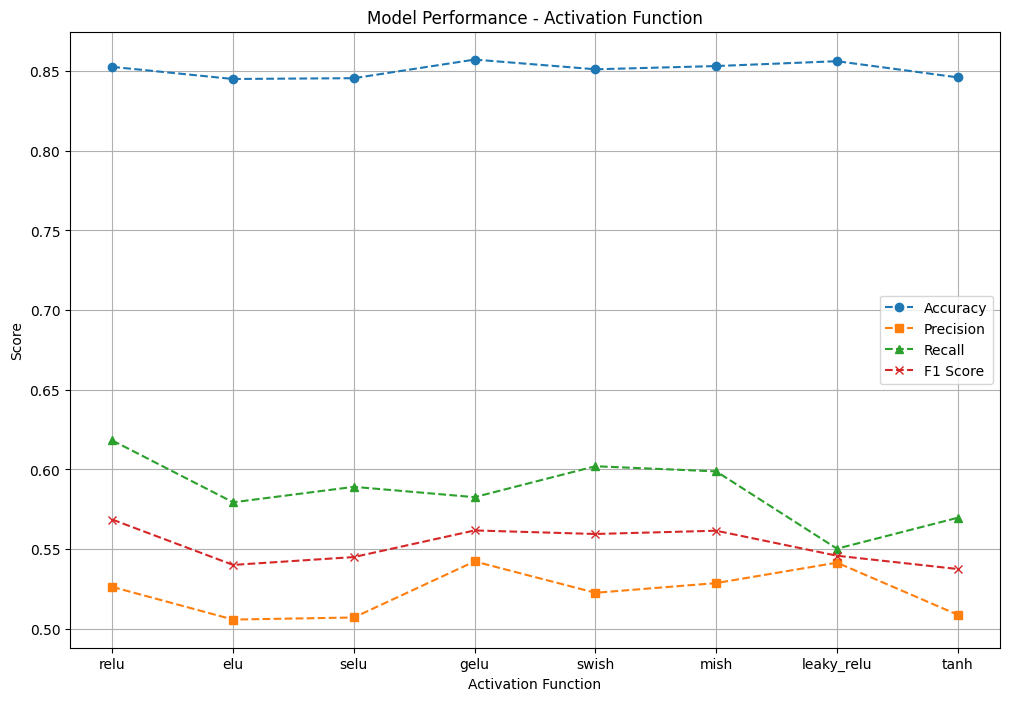

In [ ]:
# @title
# Creating a plot to show the performance of the model for Activation Function
plt.figure(figsize=(12, 8))

plt.plot(activation_funcs, ac_accuracies, label='Accuracy', marker='o', linestyle='--')
plt.plot(activation_funcs, ac_precisions, label='Precision', marker='s', linestyle='--')
plt.plot(activation_funcs, ac_recalls, label='Recall', marker='^', linestyle='--')
plt.plot(activation_funcs, ac_f1_scores, label='F1 Score', marker='x', linestyle='--')

plt.xlabel('Activation Function')
plt.ylabel('Score')
plt.title('Model Performance - Activation Function')
plt.legend()
plt.grid(True)
plt.show()


The above plot shows different activation functions performance based on the accuracy, precision, recall and F1 score. The accuracy line for all the activation function remains around 85%. But all other matrices remain below 65% which shows a lack of predictive ability to actually identify good match.

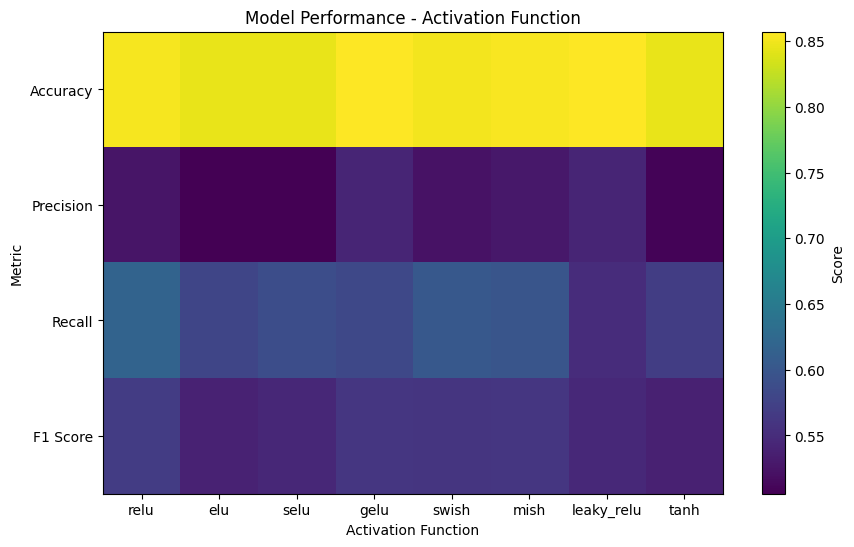

In [ ]:
# @title
# Combine the performance metrics into a single matrix
metrics_matrix = np.array([ac_accuracies, ac_precisions, ac_recalls, ac_f1_scores])

# Creating a heatmap to show the metrics
plt.figure(figsize=(10, 6))
plt.imshow(metrics_matrix, cmap='viridis', aspect='auto')
plt.xticks(np.arange(len(activation_funcs)), activation_funcs)
plt.yticks(np.arange(4), ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.colorbar(label='Score')
plt.xlabel('Activation Function')
plt.ylabel('Metric')
plt.title('Model Performance - Activation Function')
plt.show()


The heatmap above shows a visual comparison among the various activation function. We can see that there's no clear winner in this, only slightly better alternatives.

# 6. Complex models

In general, the problem of matching a whole document with a provided topics can be attritube to the broader topics of textual similarity, or sentence similarity, so below we will explore severall approach that incorporated ideas within representation models, interaction models and pre-trained models.

In [ ]:
# @title
import pickle
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.layers import GlobalMaxPool2D, GlobalAvgPool2D, Multiply, Subtract, Add, Activation, MaxPool2D, Concatenate,Reshape, Conv2D, MaxPooling2D, Dropout, Input, Embedding, Bidirectional, LSTM, Dense, Lambda, GlobalAveragePooling1D, Reshape, GRU, Flatten, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.activations import gelu
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import zipfile
import os
# Setting epoch_count = 1 just to let the file run as demo, we have saved the trained models in a separated folder and will be using this to review
epoch_count = 1
# Checking for GPU
len(tf.config.list_physical_devices('GPU'))

In this part, along with the typical singple input model, we will also be consider a **Siamese** model architecture, with 2 separate inputs, each for 'topic' and 'document' that will be later merge into 1 binary output layer downstream. With these approach so we will have in total 3 different set of features, one each for 'document' and 'topic', and one for 'concatenatex_text', which is the combination of the first 2.

In [ ]:
# @title
X,y = training_df2[['document','topic','concatenated_text']],training_df2['judgement']

# For a train-validate-test ratio of 0.85/0.1/0.05

# Split data into train and tempt (combined of validate and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)

# Split tempt to validate and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

X_train_doc,X_train_topic = X_train['document'].values, X_train['topic'].values
X_val_doc,X_val_topic = X_val['document'].values, X_val['topic'].values
X_test_doc,X_test_topic = X_test['document'].values, X_test['topic'].values

X_train_concat = X_train['concatenated_text'].values
X_val_concat = X_val['concatenated_text'].values
X_test_concat = X_test['concatenated_text'].values

As stated above, since we are looking to find the matching document with the provided topic, se while the 'judgement' are binary, we are mostly interest in the minority class, or y = 1, indicating that the document is relevant to the provided topics. Because of the imbalancy, so accuracy can be a misleading metrics, while taking into account multiple metrics like accuracy, precision, recall at once can make poor comparison, so we will mainly base our calculation on F1-Score. Due to tensorflow does not include f1 score as metrics, so we have to defined our own incorporating into tensorflow backend

In [ ]:
# @title
# Setting up f1_score function for use during training process
def f1_score_metrics(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score_metrics,
]
# Prepare a dictionary to record result
dl_results={}
# Setting up function to measure the models performance
def dl_metrics(test_pred, test_label,model_name,threshold=0.5):
    binary_test_pred = (test_pred > threshold).astype(int)
    report = classification_report(test_label, binary_test_pred)
    print(report)
    accuracy = accuracy_score(test_label, binary_test_pred)
    precision = precision_score(test_label, binary_test_pred)
    recall = recall_score(test_label, binary_test_pred)
    f1 = f1_score(test_label, binary_test_pred)
    pred_count = sum(binary_test_pred)
    print('Total predictions: ', pred_count)
    dl_results[model_name] = [accuracy, precision,recall,f1,pred_count]

# Rebalance the classes weights
# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Code to zip
def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through all the files in the folder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Add each file to the zip file
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# callback functions
lrd = ReduceLROnPlateau(monitor='val_loss',
                        patience=5, # reduce lr every 5 epochs with no improvement
                        verbose=1,
                        factor=0.7, # reduction factor
                        min_lr=1e-4) # minimum lr
mcp = ModelCheckpoint('model.h5.keras',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,  # Save 1 optimal model
                      mode='min') # Since we are looking to miniamize loss
es = EarlyStopping(monitor='val_loss',verbose=1,
                   patience=15, # early stop after 15 consecutive epochs with no improvement
                   mode='min',# Since we are looking to miniamize loss
                   restore_best_weights=True) # Revert back to version with best loss

## 6.1. Generating word Embedding using GloVe
There are different option for pre-trained dataset but we choose GloVe 6B, with the 300 dimension variant, as it was based on Wikipedia 2014 anđ Gigaword5, which are intuitively related to the vocabulary of the text we are processing, also because it's relatively light weight to incorporate into our models. We hope that using GloVe will provide our model with global semantic representation and generalization, based on the dataset it was trained on.

In [ ]:
# @title
# Load GloVe embeddings
def load_glove_embeddings(embedding_path):
    embedding_index = {}
    with open(embedding_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    return embedding_index

embedding_dim = 300

# Load GloVe embeddings
glove_path = '/kaggle/input/glove-6b/glove.6B.'+ str(embedding_dim) +'d.txt'
glove_embeddings_index = load_glove_embeddings(glove_path)

# Custom function to map words to GloVe embeddings
def map_word_to_glove(word):
    return glove_embeddings_index.get(word, np.zeros(embedding_dim)) # 300 is the dimensionality of GloVe embeddings

# Define a function to convert text to embeddings using the vectorizer and custom mapping
def text_to_embedding(text):
    words = tf.strings.split(text)
    embeddings = tf.map_fn(lambda word: tf.py_function(map_word_to_glove, [word], Tout=tf.float32), words)
    return embeddings

In [ ]:
# @title
doc_max_sequence_length = 500
doc_max_tokens = 5000

topic_max_sequence_length = 500
topic_max_tokens = 500

concat_max_sequence_length = 1000
concat_max_tokens = 10000

# Create a TextVectorization layer with custom standardization and mapping function
topic_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=topic_max_tokens,
    output_mode='int',
    output_sequence_length=topic_max_sequence_length,
    standardize=None,  # Disable standardization

)
topic_vectorizer.adapt(X_train['topic'])

# Create a TextVectorization layer with custom standardization and mapping function
doc_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=doc_max_tokens,
    output_mode='int',
    output_sequence_length=doc_max_sequence_length,
    standardize=None,  # Disable standardization
)
doc_vectorizer.adapt(X_train['document'])

# Create a TextVectorization layer with custom standardization and mapping function
concat_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=concat_max_tokens,
    output_mode='int',
    output_sequence_length=concat_max_sequence_length,
    standardize=None,  # Disable standardization

)
concat_vectorizer.adapt(X_train['concatenated_text'])

In [ ]:
# @title
# Get the vocabulary from the topic_vectorizer
topic_vocab = topic_vectorizer.get_vocabulary()
doc_vocab = doc_vectorizer.get_vocabulary()
concat_vocab = concat_vectorizer.get_vocabulary()

# Initialize an empty list to store the embeddings
topic_embedding = []
doc_embedding = []
concat_embedding = []
# Iterate through the vocabulary and map each word to its GloVe embedding
for word in topic_vocab:
    topic_embedding.append(map_word_to_glove(word))

for word in doc_vocab:
    doc_embedding.append(map_word_to_glove(word))

for word in concat_vocab:
    concat_embedding.append(map_word_to_glove(word))


# Convert the list of embedding vectors to a numpy array
topic_embedding = np.array(topic_embedding)
doc_embedding = np.array(doc_embedding)
concat_embedding = np.array(concat_embedding)

# Check the shape of the embedding matrix
print("Shape of topic embedding:", topic_embedding.shape)
print("Shape of document embedding:", doc_embedding.shape)
print("Shape of concatened text embedding:", concat_embedding.shape)

Shape of topic embedding: (500, 300)
Shape of document embedding: (5000, 300)
Shape of concatened text embedding: (10000, 300)


## 6.1. Deep NN with GloVe Embedding

### 6.1.1. Deep NN on concatenated text with just embedding layer

In [ ]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.string, name='concat_input')

# Use the tokenizer for each types
concat_tokens = doc_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                    output_dim=embedding_dim,
                                                    #input_length=concat_max_sequence_length,
                                                   mask_zero=True)(concat_tokens)

# Flatten the input if needed
flattened_input = tf.keras.layers.Flatten()(concat_embedding_layer)

# Define dense layers with L2 regularization
dense1 = Dense(50, activation='gelu', kernel_regularizer=regularizers.l2(0.01))(flattened_input)
dropout1 = Dropout(0.5)(dense1)  # Add dropout
dense2 = Dense(50, activation='gelu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(dense2)  # Add dropout
dense3 = Dense(50, activation='gelu', kernel_regularizer=regularizers.l2(0.01))(dropout2)


# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dense3)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score_metrics])#METRICS)

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 500, 300)          3000000   
                                                                 
 flatten (Flatten)           (None, 150000)            0         
                                                                 
 dense_95 (Dense)            (None, 50)                7500050   
                                                                 
 dropout_69 (Dropout)        (None, 50)                0         
                                                             

In [ ]:
# @title
dense_history = model.fit(X_train_concat, y_train,
            batch_size=128,
            epochs=epoch_count,
            validation_data=(X_val_concat, y_val),
            class_weight = class_weights_dict
            #callbacks=[lrd,mcp,es]
            )

131/131 [==============================] - 23s 148ms/step - loss: 1.3310 - accuracy: 0.5131 - f1_score_metrics: 0.2805 - val_loss: 0.9361 - val_accuracy: 0.7741 - val_f1_score_metrics: 0.3700


In [ ]:
# @title
# Setting up model name
model_name = 'Dense_NN'
# make a prediction and save result
test_pred = model.predict(X_test_concat)

dl_metrics(test_pred.flatten(),y_test, model_name)
# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

31/31 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       821
           1       0.34      0.45      0.39       154

    accuracy                           0.77       975
   macro avg       0.61      0.64      0.62       975
weighted avg       0.80      0.77      0.79       975

Total predictions:  208


In [ ]:
# @title
# Save dense_history
with open('dense_history.pkl', 'wb') as f:
    pickle.dump(dense_history.history, f)

# Load dense_history
with open('dense_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

### 6.1.2. Deep NN on concatenated text with GloVe 300d as initiator
The main goal of this experimentation is to see if the Embedding will improve the training result - The results during the process indicate a slight imporvement interm of F1-score but only by around 2%

In [ ]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.string, name='concat_input')

# Use the tokenizer for each types
concat_tokens = doc_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                      output_dim=embedding_dim,
                                                     weights=[concat_embedding],
                                                      #input_length=concat_max_sequence_length,
                                                      trainable=True, mask_zero=True)(concat_tokens)

# Flatten the input if needed
flattened_input = tf.keras.layers.Flatten()(concat_embedding_layer)

# Define dense layers with L2 regularization
dense1 = Dense(50, activation='gelu', kernel_regularizer=regularizers.l2(0.01))(flattened_input)
dropout1 = Dropout(0.5)(dense1)  # Add dropout
dense2 = Dense(50, activation='gelu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(dense2)  # Add dropout
dense3 = Dense(50, activation='gelu', kernel_regularizer=regularizers.l2(0.01))(dropout2)

# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dense3)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score_metrics])#METRICS)

# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 500, 300)          3000000   
                                                                 
 flatten_1 (Flatten)         (None, 150000)            0         
                                                                 
 dense_99 (Dense)            (None, 50)                7500050   
                                                                 
 dropout_71 (Dropout)        (None, 50)                0         
                                                           

In [ ]:
# @title
dense_glove_history = model.fit(X_train_concat, y_train,
            batch_size=128,
            epochs=epoch_count,
            validation_data=(X_val_concat, y_val),
            class_weight = class_weights_dict,
            #callbacks=[lrd,mcp,es]
            )

131/131 [==============================] - 14s 94ms/step - loss: 2.0480 - accuracy: 0.5062 - f1_score_metrics: 0.2350 - val_loss: 1.3430 - val_accuracy: 0.6529 - val_f1_score_metrics: 0.2437


In [ ]:
# @title
# Setting up model name
model_name = 'Dense_GloVe'
# make a prediction and save result
test_pred = model.predict(X_test_concat)

dl_metrics(test_pred.flatten(),y_test, model_name)

# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

31/31 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       821
           1       0.20      0.40      0.27       154

    accuracy                           0.66       975
   macro avg       0.53      0.55      0.52       975
weighted avg       0.76      0.66      0.70       975

Total predictions:  303


In [ ]:
# @title
# Save dense_history
with open('dense_glove_history.pkl', 'wb') as f:
    pickle.dump(dense_history.history, f)

# Load dense_history
with open('dense_glove_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

## 6.2. Glove with LSTM and BiLSTM
As LSTM are mainly for sequential data such as text so we are experimenting to see if there is a clear improvement with just LSTM - though since we are looking for textual similarity, which might be outside of sequential pattern.

### 6.2.1. LSTM

In [ ]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                      dtype=tf.string, name='concat_input')

# Use the tokenizer for each type
concat_tokens = doc_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                   output_dim=embedding_dim,
                                                   weights=[concat_embedding],
                                                   #input_length=concat_max_sequence_length,
                                                   trainable=True, mask_zero=True)(concat_tokens)

# LSTM layers with dropout and regularizers
lstm1 = LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(concat_embedding_layer)
dropout1 = Dropout(0.5)(lstm1)  # Add dropout
lstm2 = LSTM(50, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(lstm2)  # Add dropout

# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout2)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metrics])

# Print model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 500, 300)          3000000   
                                                                 
 lstm (LSTM)                 (None, 500, 50)           70200     
                                                                 
 dropout_73 (Dropout)        (None, 500, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                           

In [ ]:
# @title
lstm_glove_history = model.fit(X_train_concat, y_train,
            batch_size=128,
            epochs=epoch_count,
            validation_data=(X_val_concat, y_val),
            class_weight = class_weights_dict,
            callbacks=[lrd,mcp,es]
            )

131/131 [==============================] - ETA: 0s - loss: 1.9074 - accuracy: 0.5649 - f1_score_metrics: 0.2889
Epoch 1: val_loss improved from inf to 0.82686, saving model to model.h5.keras
131/131 [==============================] - 32s 169ms/step - loss: 1.9074 - accuracy: 0.5649 - f1_score_metrics: 0.2889 - val_loss: 0.8269 - val_accuracy: 0.5867 - val_f1_score_metrics: 0.3419 - lr: 0.0010


In [ ]:
# @title
# Save dense_history
with open('lstm_glove_history.pkl', 'wb') as f:
    pickle.dump(dense_history.history, f)

# Load dense_history
with open('lstm_glove_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
# @title
# Setting up model name
model_name = 'lstm_GloVe'
# make a prediction and save result
test_pred = model.predict(X_test_concat)

dl_metrics(test_pred.flatten(),y_test, model_name)

# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

31/31 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

           0       0.91      0.57      0.71       821
           1       0.24      0.71      0.36       154

    accuracy                           0.60       975
   macro avg       0.58      0.64      0.53       975
weighted avg       0.81      0.60      0.65       975

Total predictions:  459


### 6.2.2. Bidirectional LSTM

In [ ]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                      dtype=tf.string, name='concat_input')

# Use the tokenizer for each type
concat_tokens = doc_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                   output_dim=embedding_dim,
                                                   weights=[concat_embedding],
                                                   #input_length=concat_max_sequence_length,
                                                   trainable=True, mask_zero=True)(concat_tokens)

# LSTM layers with dropout and regularizers
lstm1 =  Bidirectional(LSTM(50, return_sequences=True,
                            kernel_regularizer=regularizers.l2(0.01),
                            recurrent_regularizer=regularizers.l2(0.01)))(concat_embedding_layer)
dropout1 = Dropout(0.5)(lstm1)  # Add dropout
lstm2 =  Bidirectional(LSTM(50, kernel_regularizer=regularizers.l2(0.01),
                            recurrent_regularizer=regularizers.l2(0.01)))(dropout1)
dropout2 = Dropout(0.5)(lstm2)  # Add dropout

# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout2)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metrics])

# Print model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 500, 300)          3000000   
                                                                 
 bidirectional (Bidirection  (None, 500, 100)          140400    
 al)                                                             
                                                                 
 dropout_75 (Dropout)        (None, 500, 100)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               6040

In [ ]:
# @title
bilstm_glove_history = model.fit(X_train_concat, y_train,
            batch_size=128,
            epochs=epoch_count,
            validation_data=(X_val_concat, y_val),
            class_weight = class_weights_dict,
            #callbacks=[lrd,mcp,es]
            )

131/131 [==============================] - 53s 255ms/step - loss: 3.3999 - accuracy: 0.5735 - f1_score_metrics: 0.2936 - val_loss: 0.9154 - val_accuracy: 0.6913 - val_f1_score_metrics: 0.3786


In [ ]:
# @title
# Save dense_history
with open('bilstm_glove_history.pkl', 'wb') as f:
    pickle.dump(dense_history.history, f)

# Load dense_history
with open('bilstm_glove_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
# @title
# Setting up model name
model_name = 'bilstm_GloVe'
# make a prediction and save result
test_pred = model.predict(X_test_concat)

dl_metrics(test_pred.flatten(),y_test, model_name)

# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

31/31 [==============================] - 7s 43ms/step
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       821
           1       0.28      0.67      0.39       154

    accuracy                           0.68       975
   macro avg       0.60      0.67      0.59       975
weighted avg       0.82      0.68      0.72       975

Total predictions:  368


## 6.3. Siamese Neural Network with GloVe embedding
This is just a separate test to see if the Siamese architecture by itself help imporve performance


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 topic_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['document_input[0][0]']      
 Vectorization)                                                                                   
                                                                                            

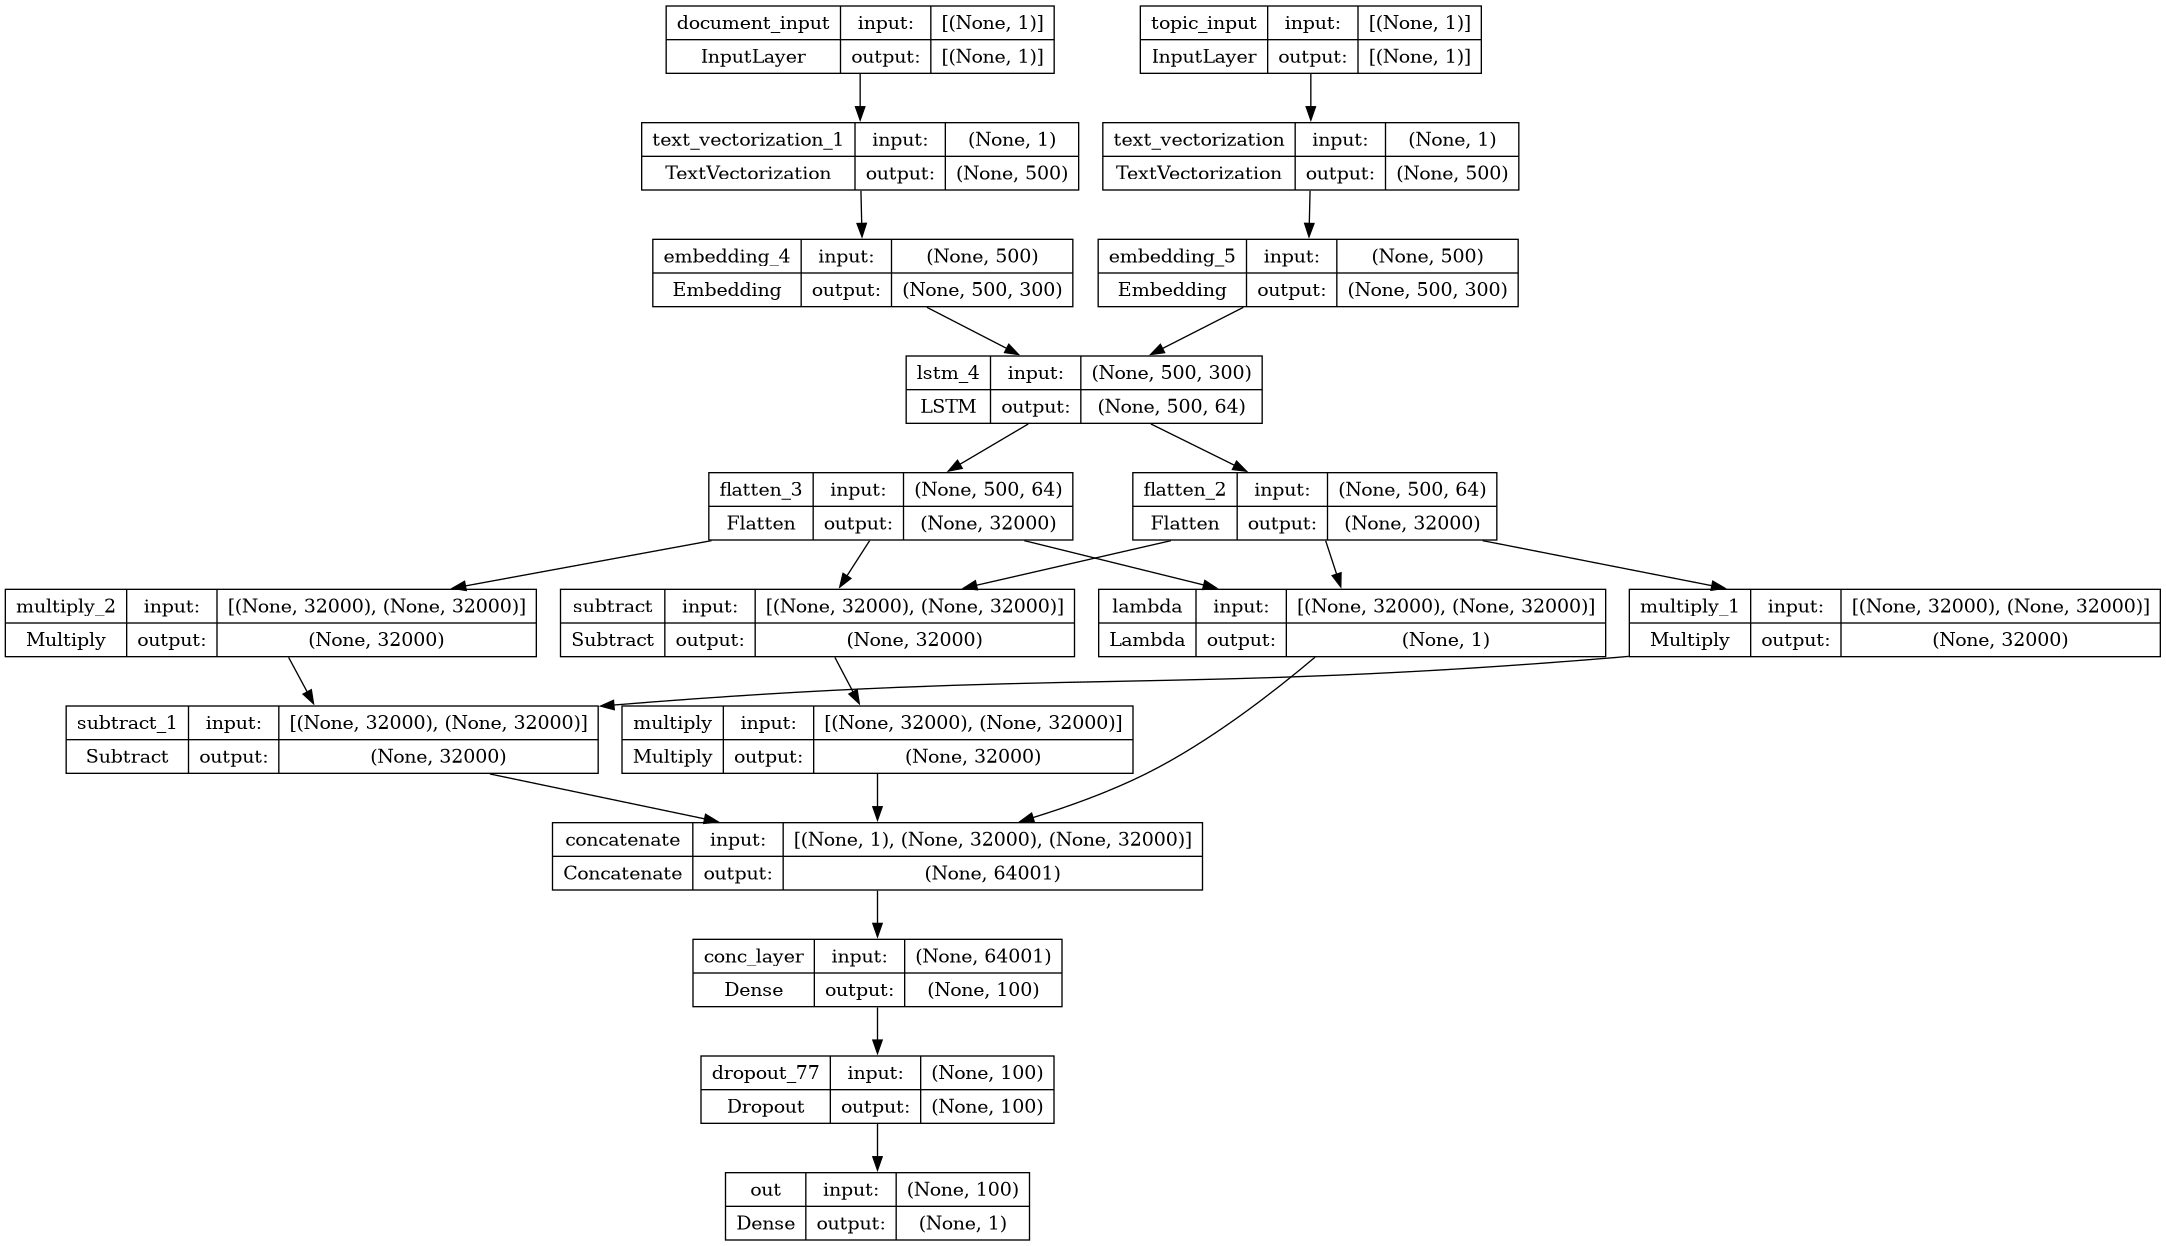

In [ ]:
# @title
def auroc(y_true, y_pred):
    auc = tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)
    return auc
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)
# Define input layers for 'document' and 'topic'
document_input = tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.string, name='document_input')
topic_input = tf.keras.layers.Input(shape=(1,),
                                    dtype=tf.string, name='topic_input')

# Use the tokenizer for each types
document_tokens = doc_vectorizer(document_input)

topic_tokens = topic_vectorizer(topic_input)

# Embedding layer for 'document'
document_embedding_layer = tf.keras.layers.Embedding(input_dim=len(doc_vocab),
                                                      output_dim=embedding_dim,
                                                     weights=[doc_embedding],
                                                      #input_length=doc_max_sequence_length,
                                                      trainable=True, mask_zero=True)(document_tokens)

# Embedding layer for 'topic'
topic_embedding_layer = tf.keras.layers.Embedding(input_dim=len(topic_vocab),
                                                  output_dim=embedding_dim,
                                                  weights=[topic_embedding],
                                                  #input_length=topic_max_sequence_length,
                                                  trainable=True, mask_zero=True)(topic_tokens)
lstm_1 = document_embedding_layer
lstm_2 = topic_embedding_layer


common_lstm = LSTM(64,return_sequences=True, activation="relu")
vector_1 = common_lstm(lstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_lstm(lstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])

    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([document_input, topic_input], out)

model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

model.summary()

plot_model(model,show_shapes=True,to_file = 'simese_glove_cosine_architecture.png')

In [ ]:
# @title
# Train the model
simese_glove_cosine_history = model.fit([X_train_doc,X_train_topic], y_train,
            batch_size= 512 #128, # to quick things up
            epochs=epoch_count,
            validation_data=([X_val_doc, X_val_topic], y_val),
            class_weight = class_weights_dict,
            #callbacks=[lrd,mcp,es]
            )

131/131 [==============================] - 255s 2s/step - loss: 0.6562 - acc: 0.6009 - auroc: 0.6636 - val_loss: 0.6398 - val_acc: 0.6124 - val_auroc: 0.6882


In [ ]:
# @title
# Save dense_history
with open('simese_glove_cosine_history.pkl', 'wb') as f:
    pickle.dump(dense_history.history, f)

# Load dense_history
with open('simese_glove_cosine_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
# @title
# Setting up model name
model_name = 'siamese_glove_cosine'
# make a prediction and save result
test_pred = model.predict([X_test_doc, X_test_topic])

dl_metrics(test_pred.flatten(),y_test, model_name)

# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

31/31 [==============================] - 6s 187ms/step
              precision    recall  f1-score   support

           0       0.91      0.62      0.73       821
           1       0.24      0.66      0.35       154

    accuracy                           0.62       975
   macro avg       0.57      0.64      0.54       975
weighted avg       0.80      0.62      0.67       975

Total predictions:  416


## 6.3 CNN with GloVe
CNN while mainly applicable for iamges, it still potentially a good tool to capture local pattern

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 topic_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['document_input[0][0]']      
 Vectorization)                                                                                   
                                                                                            

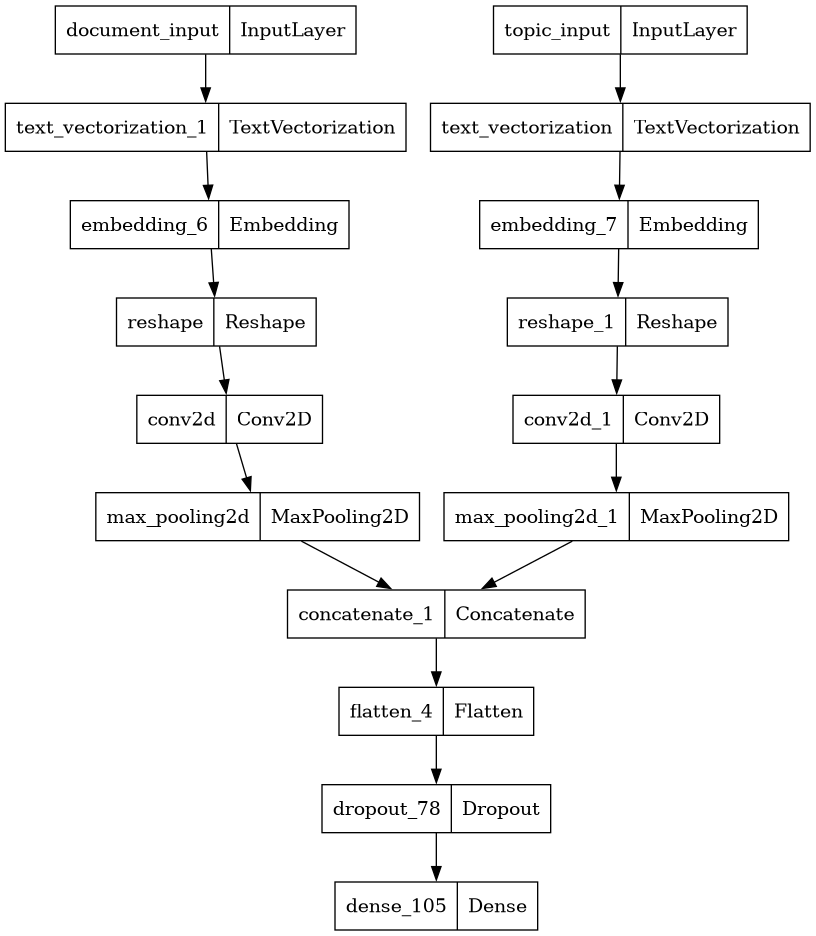

In [ ]:
# @title
# Define input layers for 'document' and 'topic'
document_input = tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.string, name='document_input')
topic_input = tf.keras.layers.Input(shape=(1,),
                                    dtype=tf.string, name='topic_input')

# Use the tokenizer for each types
document_tokens = doc_vectorizer(document_input)

topic_tokens = topic_vectorizer(topic_input)

# Embedding layer for 'document'
document_embedding_layer = tf.keras.layers.Embedding(input_dim=len(doc_vocab),
                                                      output_dim=embedding_dim,
                                                      weights=[doc_embedding],
                                                      #input_length=doc_max_sequence_length,
                                                      trainable=True, mask_zero=True)(document_tokens)

# Embedding layer for 'topic'
topic_embedding_layer = tf.keras.layers.Embedding(input_dim=len(topic_vocab),
                                                  output_dim=embedding_dim,
                                                  weights=[topic_embedding],
                                                  #input_length=topic_max_sequence_length,
                                                  trainable=True, mask_zero=True)(topic_tokens)

# Reshape document embedding layer
reshape1 = Reshape((doc_max_sequence_length, embedding_dim, 1))(document_embedding_layer)
# Convolutional layer
conv1 = Conv2D(64, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape1)
# Pooling layer
pool1 = MaxPooling2D(pool_size=(doc_max_sequence_length - 3, 1))(conv1)

# Reshape topic embedding layer
reshape2 = Reshape((topic_max_sequence_length, embedding_dim, 1))(topic_embedding_layer)
# Convolutional layer
conv2 = Conv2D(64, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape2)
# Pooling layer
pool2 = MaxPooling2D(pool_size=(topic_max_sequence_length - 3, 1))(conv2)

merged = keras.layers.concatenate([pool1, pool2])

flat = keras.layers.Flatten()(merged)
dropout = keras.layers.Dropout(0.5)(flat)
output = Dense(1, activation='sigmoid')(dropout)
model = keras.Model(inputs=[document_input, topic_input], outputs=output)

# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score_metrics])

model.summary()

plot_model(model)

In [ ]:
# @title
# Train the model
cnn_history = model.fit([X_train_doc,X_train_topic], y_train,
            batch_size=128,
            epochs=epoch_count,
            validation_data=([X_val_doc, X_val_topic], y_val),
            class_weight = class_weights_dict,
            #callbacks=[lrd,mcp,es]
            )

131/131 [==============================] - 25s 152ms/step - loss: 0.7578 - accuracy: 0.6119 - f1_score_metrics: 0.3300 - val_loss: 0.6024 - val_accuracy: 0.6523 - val_f1_score_metrics: 0.4113


In [ ]:
# @title
# Save dense_history
with open('cnn_history.pkl', 'wb') as f:
    pickle.dump(cnn_history.history, f)

# Load dense_history
with open('cnn_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
# @title
# Setting up model name
model_name = 'CNN_glove'
# make a prediction and save result
test_pred = model.predict([X_test_doc, X_test_topic])

dl_metrics(test_pred.flatten(),y_test, model_name)

# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

31/31 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.62      0.75       821
           1       0.28      0.78      0.41       154

    accuracy                           0.65       975
   macro avg       0.61      0.70      0.58       975
weighted avg       0.83      0.65      0.70       975

Total predictions:  429


## 6.4. Siamese with Bert sentence embedding
Due to normal Bert models tend to crash due to resource management so we consider this a light-weight alternative, but the results embedding very likely won't encapsulate much of the information from the original data

In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [ ]:
# @title
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Extract 'document' and 'topic' columns
train_documents = X_train['document'].values
train_topics = X_train['topic'].values


# Encode 'document' and 'topic' sentences using SentenceTransformer
document_embeddings = model.encode(train_documents)
topic_embeddings = model.encode(train_topics)

val_documents = X_val['document'].values
val_topics = X_val['topic'].values
val_document_embeddings = model.encode(val_documents)
val_topic_embeddings = model.encode(val_topics)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/523 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 90.12 MiB is free. Process 5140 has 15.80 GiB memory in use. Of the allocated memory 239.00 MiB is allocated by PyTorch, and 9.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# @title
# Define input layers for 'document' and 'topic'
document_input = Input(shape=(document_embeddings.shape[1],), name='document_input')
topic_input = Input(shape=(topic_embeddings.shape[1],), name='topic_input')

    #https://stackoverflow.com/a/51003359/10650182
cosine_dist = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([document_input, topic_input])

dense1 = Dense(100, activation="gelu")(cosine_dist)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(100, activation="gelu", name='conc_layer')(dropout1)
dropout2 = Dropout(0.5)(dense2)
out = Dense(1, activation="sigmoid", name = 'out')(dropout2)

model = Model([document_input, topic_input], out)

model.compile(loss="binary_crossentropy", metrics=['acc',f1_score_metrics], optimizer=Adam(0.00001))
model.summary()

plot_model(model,show_shapes=True,to_file = 'simese_bert_sent_cosine_architecture.png')

NameError: name 'document_embeddings' is not defined

In [ ]:
# @title
# Train the model
simese_bert_sent_cosine_history = model.fit([document_embeddings,topic_embeddings], y_train,
            batch_size=128,
            epochs=epoch_count,
            validation_data=([val_document_embeddings, val_topic_embeddings], y_val),
            class_weight = class_weights_dict,
            #callbacks=[lrd,mcp,es]
            )

In [ ]:
# @title
# Save dense_history
with open('simese_bert_sent_cosine.pkl', 'wb') as f:
    pickle.dump(simese_bert_sent_cosine_history.history, f)

# Load dense_history
with open('simese_bert_sent_cosine.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
# @title
# Setting up model name
model_name = 'simese_bert_sent_cosine'
# make a prediction and save result
test_pred = model.predict([X_test_doc, X_test_topic])

dl_metrics(test_pred.flatten(),y_test, model_name)

# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

In [ ]:
# @title
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Function to create the base network
def create_base_network(input_shape):
    input_layer = Input(shape=input_shape)
    x = Flatten()(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_layer, x)

# Define input shapes
document_input = Input(shape=(100,), name='document_input')
topic_input = Input(shape=(100,), name='topic_input')

# Create base networks for document and topic inputs
base_network_document = create_base_network(100)
base_network_topic = create_base_network(100)

# Process document and topic inputs separately using their respective base networks
processed_document = base_network_document(document_input)
processed_topic = base_network_topic(topic_input)

# Calculate Euclidean distance between processed document and topic vectors
distance = Lambda(euclidean_distance)([processed_document, processed_topic])

x4 = Dense(100, activation="gelu")(distance)
x3 = Dropout(0.5)(x4)

x = Dense(100, activation="gelu", name='conc_layer')(x3)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

# Define the model
model = Model([document_input, topic_input], out)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 topic_input (InputLayer)    [(None, 100)]                0         []                            
                                                                                                  
 model_6 (Functional)        (None, 128)                  45952     ['document_input[0][0]']      
                                                                                                  
 model_7 (Functional)        (None, 128)                  45952     ['topic_input[0][0]']   

In [ ]:
# @title
# Contrastive loss
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

model.compile(loss=contrastive_loss, optimizer='rmsprop', metrics = ['accuracy', f1_score_metrics])

# Train the model
history = model.fit([document_embeddings,topic_embeddings], y_train,
            batch_size=128,
            epochs=epoch_count,
            validation_split = 0.1,
#            validation_data=([X_val_doc, X_val_topic], y_val),
            class_weight = class_weights_dict,)

TypeError: compile() got an unexpected keyword argument 'loss'

## 6.6 Euclidean distance with BiLSTM
We want to try the combination of the sequential pattern and use a direct measurement for similarity - Euclidean distance to see if the model will improve performance.

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 topic_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['document_input[0][0]']      
 Vectorization)                                                                                   
                                                                                            

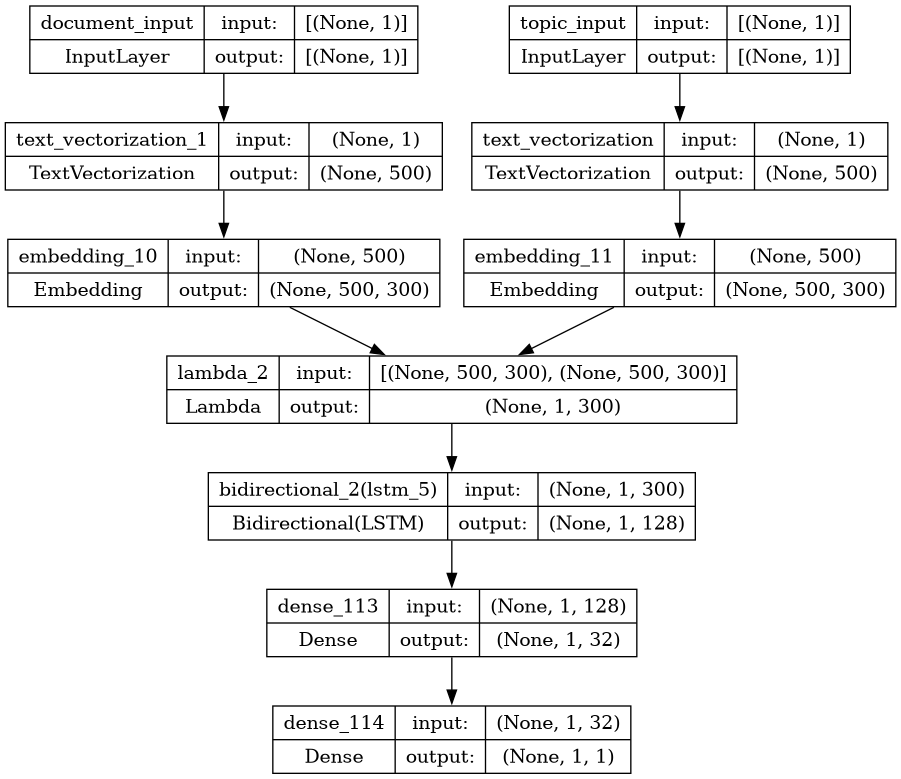

In [ ]:
# @title
# Define input layers for 'document' and 'topic'
document_input = Input(shape=(1,), dtype=tf.string, name='document_input')
topic_input = Input(shape=(1,), dtype=tf.string, name='topic_input')

# Use the tokenizer for each type
document_tokens = doc_vectorizer(document_input)
topic_tokens = topic_vectorizer(topic_input)

# Embedding layer for 'document'
document_embedding_layer = tf.keras.layers.Embedding(input_dim=len(doc_vocab),
                                                      output_dim=embedding_dim,
                                                     weights=[doc_embedding],
                                                      #input_length=doc_max_sequence_length,
                                                      trainable=True, mask_zero=True)(document_tokens)

# Embedding layer for 'topic'
topic_embedding_layer = tf.keras.layers.Embedding(input_dim=len(topic_vocab),
                                                  output_dim=embedding_dim,
                                                  weights=[topic_embedding],
                                                  #input_length=topic_max_sequence_length,
                                                  trainable=True, mask_zero=True)(topic_tokens)

distance = Lambda(euclidean_distance)([document_embedding_layer, topic_embedding_layer])

# Bidirectional LSTM layers for 'document' and 'topic'
bidirectional_lstm_document = Bidirectional(LSTM(units=64, activation=gelu, return_sequences=True, dropout=0.5))(distance)
bidirectional_lstm_topic = Bidirectional(LSTM(units=64, activation=gelu, return_sequences=True, dropout=0.5))(distance)

# Dense layer
dense_combined = Dense(units=32, activation=gelu)(bidirectional_lstm_document)


# Dense layer
output = Dense(units=1, activation='sigmoid')(dense_combined)

# Define the model
model = Model(inputs=[document_input, topic_input], outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score_metrics])

# Print the model summary
model.summary()

# Visualize the model architecture and save it to a file
plot_model(model, to_file='bidirectional_lstm_model_architect.png', show_shapes=True)

In [ ]:
# @title
# Training the model
glove_bilstm_euclid_history = model.fit([X_train_doc,X_train_topic], y_train,
                              epochs=epoch_count,
            batch_size=128,
            validation_data=([X_val_doc, X_val_topic], y_val),
            class_weight = class_weights_dict,
            #callbacks=[lrd,mcp,es]
            )

131/131 [==============================] - 25s 146ms/step - loss: 0.7578 - accuracy: 0.5096 - f1_score_metrics: 0.2538 - val_loss: 0.7320 - val_accuracy: 0.2122 - val_f1_score_metrics: 0.2714


In [ ]:
# @title
# Save dense_history
with open('glove_bilstm_euclid_history.pkl', 'wb') as f:
    pickle.dump(glove_bilstm_euclid_history.history, f)

# Load dense_history
with open('glove_bilstm_euclid_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
# @title
# Setting up model name
model_name = 'bilstm_euclid_glove'

# make a prediction and save result
test_pred = model.predict([X_test_doc,X_test_topic])

dl_metrics(test_pred.flatten(),y_test, model_name)

# Saving the trained model
model.save(model_name)

# Specify the folder to be zipped and the path to save the zip file
zip_file_path = model_name + '.zip'

# Call the function to zip the folder
zip_folder(model_name, zip_file_path)

31/31 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.09      0.17       821
           1       0.17      0.97      0.28       154

    accuracy                           0.23       975
   macro avg       0.55      0.53      0.23       975
weighted avg       0.82      0.23      0.19       975

Total predictions:  894


# 7. Results
The Kaggle results for the Bidirectional GloVe model using Euclidean distance on Kaggle return **0.86595**
But since we have mentioned above, with an imbalance dataset such as this, the accuracy metric is very misleading


# Key Learning

A. Deep Neural Networks (DNNs):
- While increasing layer and nodes are expected to help with boosting the learning ability, there is also a ceiling for raising these parameters
- We found that then gelu is relatively good for performing this task, the reasons can be attribute to the following reasons:
 - Smoothness and Continuity: GELU is a smooth and continuous activation function, which helps in gradient-based optimization
 - Approximation of Non-linearity: GELU is designed to approximate the non-linearities of rectified linear units

B. Complex Models :
  - **Model 1**: We identify that while Glove 6B 300d is relatively extensive, it still require tuning. If we fixed the weight based solely on GloVe, the results are worse than just using a regular Embedding layer
  - **Model 4**: The use of CNN are prone to overfitting, but seem to either lean too hard or too little, but the use of CNN is definitely potential for extracting local pattern withint the text
  - **Model 2 and 5**: The result is terrible, too much information was lost during the embedding processing.
  - **Models 6**: The overal result seem to be better than the baseline ML model but only by a few percent

  Propose direction: The use of a big-data pretrained models is definitely going to help in the training process, as it ensure stabalization and generalization. but also the mix of layers which incorporate both local interaction and global lexical co-occurrence proposed by BSSM (BERT based Siamese Semantic Model) make intuitive sense, with the idea of the soft align attention to encapsulate the interaction can be improve using other similarity measurements .

We see that the bilstm_euclid_glove model perform relatively well compare to the rest of the model, but it's not significantly better compare to the models in the DNN. But the metrics seem relatively balance, suggest that the model can actually extract featuers that potentially help identifying relevant topics.

The Bi-directoinal models converge relatively fast while the simese_glove_cosine model are relatively unstable and does not seem to be able to find any inherent pattern, which suggest that the sequential approach of Bidirectional LSTM is significantly better, rather than it is the different between the euclid or cosine distance choice.
We would recommend the Simese LSTM model using GloVe 6B 300d Ebbedding, but we understand the model left much to be desire and there are various approach we can look into to improve the model performance, including using better pre-trained embedding from BERT, and consider more hybrid approach like the Bert-based Siamese Network (BBSN) that incorporate local interactions wit

In [ ]:
# @title
from tensorflow.keras.models import load_model

# Function to load and make predictions for a single model
CNN_glove_model = load_model('/kaggle/input/trained-model/CNN_glove',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
Dense_glove_model = load_model('/kaggle/input/trained-model/Dense_GloVe',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
Dense_NN_model = load_model('/kaggle/input/trained-model/Dense_NN',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
bilstm_glove_model = load_model('/kaggle/input/trained-model/bilstm_GloVe',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
bilstm_euclid_glove_model = load_model('/kaggle/input/trained-model/bilstm_euclid_glove',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
lstm_glove_model = load_model('/kaggle/input/trained-model/lstm_GloVe',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
siamese_glove_cosine_model = load_model('/kaggle/input/trained-model/siamese_glove_cosine',
                       custom_objects={'auroc': auroc})
test_pred = CNN_glove_model.predict([X_test_doc, X_test_topic]).flatten()
dl_metrics(test_pred,y_test, 'CNN_glove')
test_pred = Dense_glove_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'Dense_glove')
test_pred = Dense_NN_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'Dense_NN')
test_pred = bilstm_glove_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'bilstm_glove')
test_pred = lstm_glove_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'lstm_glove')
test_pred = siamese_glove_cosine_model.predict([X_test_doc, X_test_topic]).flatten()
dl_metrics(test_pred,y_test, 'siamese_glove_cosine')
test_pred = bilstm_euclid_glove_model.predict([X_test_doc, X_test_topic]).flatten()
dl_metrics(test_pred,y_test, 'bilstm_euclid_glove')

# Convert the dictionary into a pandas DataFrame
dl_results_df = pd.DataFrame.from_dict(dl_results,
                                    orient='index',
                                    columns=['accuracy','precision','recall','f1_core','count_predictions'])
# Display the results as a table
print("Model Performance Comparison:")
dl_results_df

31/31 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       821
           1       0.15      0.19      0.17       154

    accuracy                           0.71       975
   macro avg       0.50      0.50      0.50       975
weighted avg       0.73      0.71      0.72       975

Total predictions:  189
31/31 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       821
           1       0.46      0.53      0.49       154

    accuracy                           0.83       975
   macro avg       0.69      0.71      0.70       975
weighted avg       0.84      0.83      0.83       975

Total predictions:  178
31/31 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       821
           1       0.53      0

,accuracy,precision,recall,f1_core,count_predictions
Dense_NN,0.851282,0.530612,0.506494,0.518272,147
Dense_GloVe,0.827692,0.460674,0.532468,0.493976,178
lstm_GloVe,0.596923,0.239651,0.714286,0.358891,459
bilstm_GloVe,0.675897,0.279891,0.668831,0.394636,368
siamese_glove_cosine,0.767179,0.363296,0.629870,0.460808,267
CNN_glove,0.707692,0.153439,0.188312,0.169096,189
bilstm_euclid_glove,0.868718,0.600000,0.506494,0.549296,130
Dense_glove,0.827692,0.460674,0.532468,0.493976,178
bilstm_glove,0.819487,0.432099,0.454545,0.443038,162
lstm_glove,0.748718,0.314286,0.500000,0.385965,245


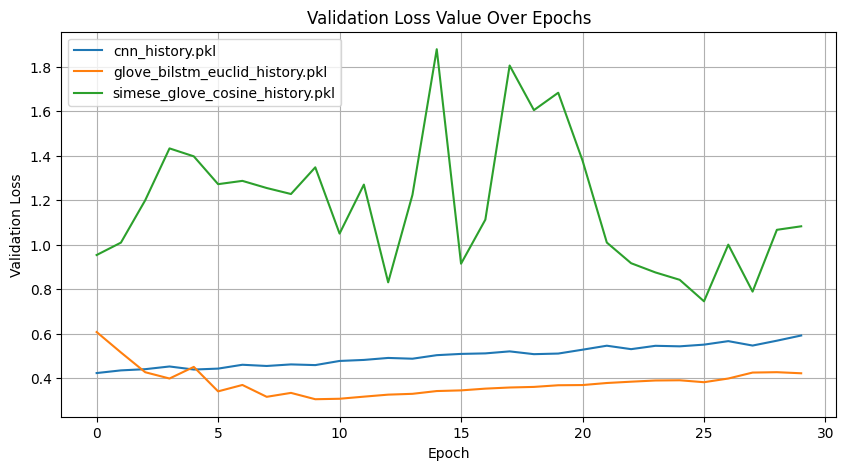

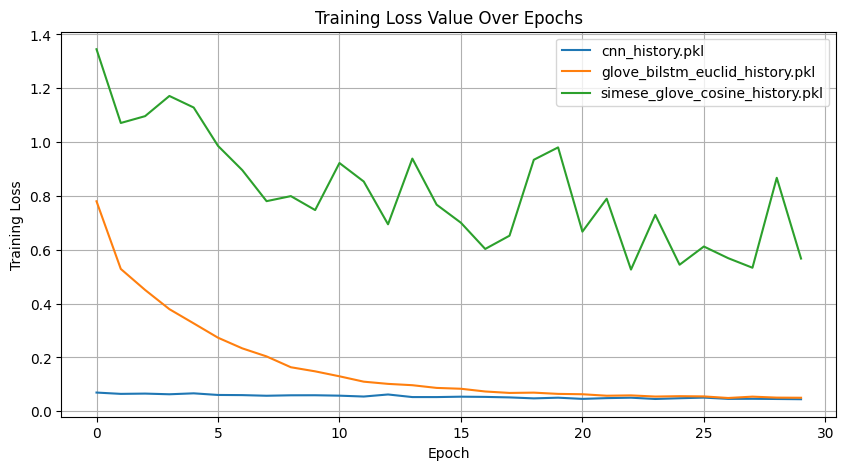

In [ ]:
# @title
import os
import pickle
import matplotlib.pyplot as plt

# Directory containing pickle files
directory = '/kaggle/input/trained-model'

# List of pickle files
pickle_files = [
    "cnn_history.pkl",
    "glove_bilstm_euclid_history.pkl",
    "simese_glove_cosine_history.pkl"
]

# Plot validation loss
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
for file in pickle_files:
    filepath = os.path.join(directory, file)
    with open(filepath, 'rb') as f:
        history = pickle.load(f)

    # Extract validation loss values
    val_loss = history['val_loss']

    # Plot validation loss
    plt.plot(val_loss, label=file)

# Set labels and legend
plt.title('Validation Loss Value Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training loss
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
for file in pickle_files:
    filepath = os.path.join(directory, file)
    with open(filepath, 'rb') as f:
        history = pickle.load(f)

    # Extract training loss values
    loss = history['loss']

    # Plot training loss
    plt.plot(loss, label=file)

# Set labels and legend
plt.title('Training Loss Value Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()


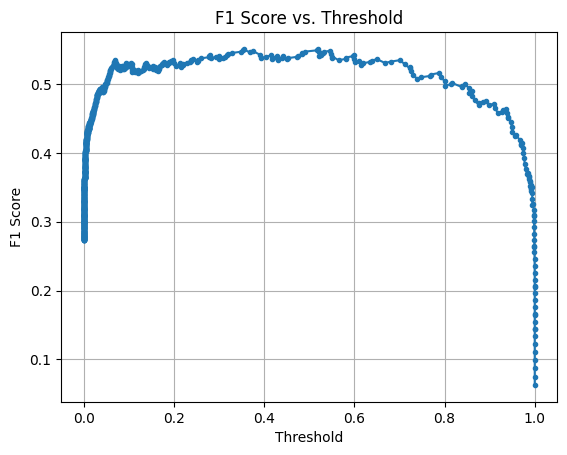

Optimal Threshold: 0.5197402
Optimal F1 Score: 0.5512367491166078


In [ ]:
# @title
# Compute precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, test_pred)

# Initialize lists to store F1 scores
f1_scores = []

# Compute F1 scores for each threshold
for i in range(len(thresholds)):
    # Compute F1 score
    f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-5)  # Adding a small value to avoid division by zero
    f1_scores.append(f1)

# Plot F1 scores
plt.plot(thresholds, f1_scores, marker='.')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()
# Initialize variables to store optimal values
optimal_threshold = None
optimal_f1_score = -1

# Iterate over each threshold and calculate F1 score
for i in range(len(thresholds)):
    threshold = thresholds[i]
    y_pred = (test_pred >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > optimal_f1_score:
        optimal_f1_score = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Optimal F1 Score:", optimal_f1_score)

In [ ]:
# @title
testing_doc = testing_df['document'].values
testing_topic = testing_df['topic'].values

testing_pred = bilstm_euclid_glove_model.predict((testing_doc,testing_topic))
testing_df['prediction'] = (testing_pred>0.5197402).astype('int')
testing_df.to_csv('output.csv')

153/153 [==============================] - 1s 6ms/step


In [ ]:
# @title
#References

#"Developing and Evaluating Siamese Neural Networks: A Comprehensive Guide to Architecture" by Dr. Isaac Faber. Available at: Medium

#GloVe: Global Vectors for Word Representation by Jeffrey Pennington, Richard Socher, and Christopher D. Manning. Available at: Stanford NLP

#"Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks" by Nils Reimers and Iryna Gurevych. Available at: arXiv

#"Siamese Neural Networks for One-shot Image Recognition" by Gregory Koch, Richard Zemel, and Ruslan Salakhutdinov. Available at: SpringerLink

#"Bert-based Siamese Network for Semantic Similarity" by Z Yan, H Wu, X Li, and Z Jiao. Available at: IOPscience

#GitHub repository by Rafal Jan Wojcik comparing SentenceBERT vs. Siamese LSTM. Available at: GitHub

#GitHub repository for the Sentence Transformers library by UKPLab. Available at: GitHub